In [ ]:

# Install necessary libraries for Intel optimizations
# !pip install numpy==1.26.0

!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!   qwapython -m pip install intel-extension-for-pytorch oneccl_bind_pt --extra-index-url https://pytorch-extension.intel.com/release-whl/stable/cpu/us/

!pip install intel-extension-for-pytorch
# !pip install openvino habana-torch
# !pip install opencv-python matplotlib

# !pip install numpy==1.26.0
# !pip install pennylane pennylane-qiskit
# !pip install torchquantum
# !pip install qiskit==0.43.1 qiskit-terra==0.24.1 qiskit-aer==0.12.0 qiskit-ibm-provider==0.6.1 qiskit-ibm-runtime==0.10.0
# !pip install opencv-python
!pip install openvino
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://pypi.org/simple
ERROR: Could not find a version that satisfies the requirement intel-extension-for-pytorch (from versions: none)
ERROR: No matching distribution found for intel-extension-for-pytorch

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install numpy==1.26.0
!pip install pennylane pennylane-qiskit
!pip install torchquantum
!pip install qiskit==0.43.1 qiskit-terra==0.24.1 qiskit-aer==0.12.0 qiskit-ibm-provider==0.6.1 qiskit-ibm-runtime==0.10.0
!pip install opencv-python
!pip install openvino
!pip install onnx


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.5/25.5 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.4 MB/s eta 0:00:00
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.4 MB/s eta 0:00:000

## Imports

In [ ]:
import numpy as np
import pandas as pd
import time
import cv2
import torch
import habana_frameworks.torch.core as htcore
import intel_extension_for_pytorch as ipex
import torchvision
from torchvision import utils as vutils
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torch.optim import SGD, Adam
from PIL import Image
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from statistics import mean
# import pennylane as qml
import torchquantum as tq

ModuleNotFoundError: No module named 'torchvision'

<h2>Global Variables<h2>

In [ ]:

import torch
import habana_frameworks.torch.core as htcore
import intel_extension_for_pytorch as ipex

# Set device to Habana Gaudi (HPU) if available, else fallback to CPU
device = torch.device("hpu" if torch.backends.hpu.is_available() else "cpu")
print(f"Running on device: {device}")

# Set random seed for reproducibility
random_seed = 1
learning_rate = 0.01
num_epochs = 2

# Optimize model with Intel Extension for PyTorch
def optimize_model(model, optimizer=None):
    model = ipex.optimize(model)
    if optimizer:
        model, optimizer = ipex.optimize(model, optimizer=optimizer)
        return model, optimizer
    return model

root_dir = './models'


Experiments running on: cuda:0


<h1>Data Preparation<h1>

In [ ]:
'''
Extract number of positive vs negative samples (where negative samples have an all-zero mask)
Check for files without corresponding mask and vice versa
'''
root = './dataset/archive/lgg-mri-segmentation/kaggle_3m'

no_mask = 0
no_mask_files = []
no_file = 0
no_files = []
num_empty_masks = 0
num_nonempty_masks = 0

S = 3 # number of pos/neg samples to take
empty_mask_samples = []
nonempty_mask_samples = []

img_dimensions = []
msk_dimensions = []

n_files = 0
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        n_files += 1
        img_dimensions.append(np.array(cv2.imread(os.path.join(directory, file))).shape)
        #count files with no mask
        if 'mask' not in file:
            #check if mask exists
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')
            if not os.path.exists(mask_path):
                no_mask += 1
                no_mask_files.append(os.path.join(directory, file))
        else:
            msk_dimensions.append(np.array(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED)).shape)
            #count masks with no file
            f_path = os.path.join(directory, file[:file.find('mask')-1]+'.tif')
            #check if file exists
            if not os.path.exists(f_path):
                no_file += 1
                no_files.append(os.path.join(directory, file))

            #check if mask is empty
            j = np.max(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED))
            if j > 0:
                num_nonempty_masks += 1
                if len(nonempty_mask_samples) < S:
                    nonempty_mask_samples.append(os.path.join(directory, file))
            else:
                num_empty_masks += 1
                if len(empty_mask_samples) < S:
                    empty_mask_samples.append(os.path.join(directory, file))


In [ ]:
#check variance in dimensions
print('Image Dimensions')
print(len(set(img_dimensions)))
print(set(img_dimensions))
print('Mask Dimensions')
print(len(set(msk_dimensions)))
print(set(msk_dimensions))

Image Dimensions
1
{(256, 256, 3)}
Mask Dimensions
1
{(256, 256)}


#No Mask: 0
#Mask w/ No File: 0
#Total Files 7814


<BarContainer object of 2 artists>

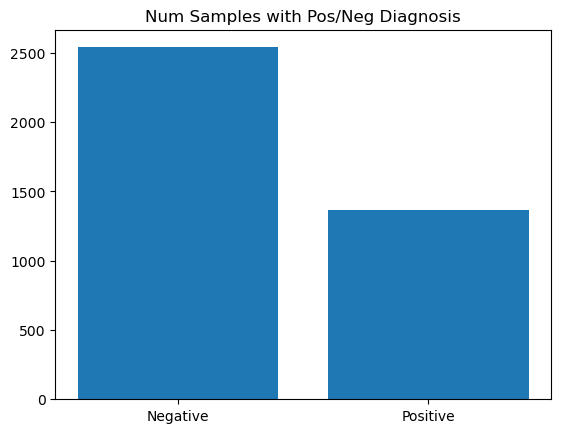

In [ ]:
print(f'#No Mask: {no_mask}')
print(f'#Mask w/ No File: {no_file}')
print(f'#Total Files {n_files}')

plt.figure()
plt.title('Num Samples with Pos/Neg Diagnosis')
plt.bar([0,1], [num_empty_masks, num_nonempty_masks], tick_label=['Negative', 'Positive'])

Luckily no files are missing their counterpart either, as some files have a completely negative diagnoses it may be a problem to train our segmentation model on an unbalanced dataset like this. A few approaches can be taken to deal with this:

1. We balance our sampling during training time to avoid biasing the segmentation algorithm, this could still be faulty
2. We employ a classifier to make a diagnoses (positive/negative) and only segment positive diagnoses

In this notebook we will assume the use of the second approach - sometimes practitioners will make this classifier another output layer of the segmenter so that they can share important features, other times we make use of transfer learning and train something like ResNet50 in order to create a robust classifier to support the segmenter. Here we out goal is mainly to increase the quality of the segmentation, so we will just train the segmenter on only positive samples.

Since we only need the positive files for training we will forget about the negative files

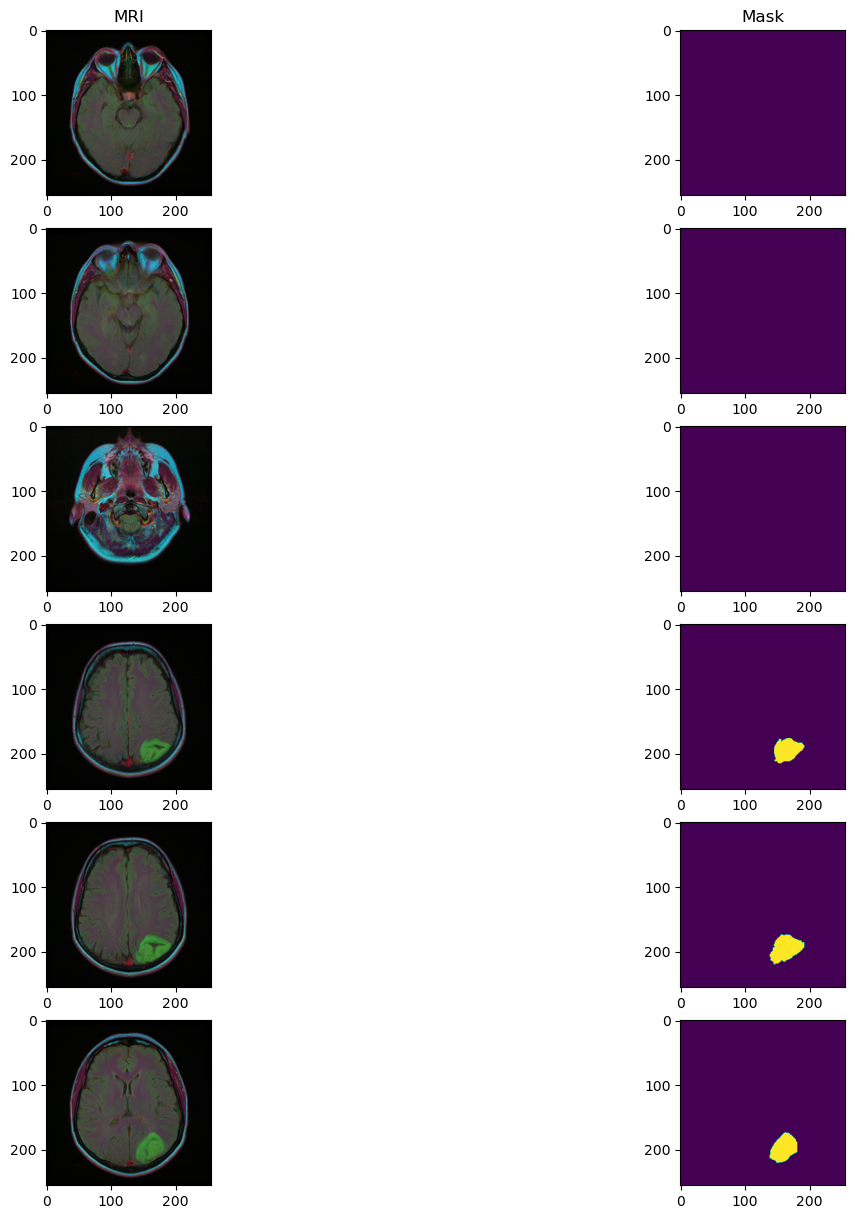

In [ ]:
#display images of negative and positive samples - negative samples have an empty mask
fig, axs = plt.subplots(6,2, figsize=(15,15))
for ax, col in zip(axs[0], ['MRI', 'Mask']):
    ax.set_title(col)

display_imgs = empty_mask_samples+nonempty_mask_samples #concat lists for easy plotting
#print(display_imgs)
for i in range(len(display_imgs)):
    mask_path = display_imgs[i]
    img_path = mask_path[:mask_path.find('mask')-1]+'.tif'
    axs[i,0].imshow(np.array(cv2.imread(img_path)))
    axs[i,1].imshow(np.array(cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)))

<h1>Create Torch Dataset<h1>

## Segementation

In [ ]:
class Brain_MRI_Segmentation_Dataset(data.Dataset):
    def __init__(self, inputs, transform=None):
        self.inputs = inputs
        self.transform = transform
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        #for classification return only the image and the binary label
        img_path = self.inputs[index][0]
        mask_path = self.inputs[index][1]
        #mask_img = cv2.normalize(cv2.imread(mask_path), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        x = torch.from_numpy(np.transpose(np.array(cv2.imread(img_path)), (2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.resize(np.array(mask_img)/255., (1,256,256))).type(self.target_dtype)

        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)

        return x,y


In [ ]:
file_list = []

for directory in [os.path.join(root, x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        # Add files to the list
        if 'mask' not in file:
            result = 0
            img_path = os.path.join(directory, file)
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')

            # Attempt to read the mask image
            mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

            # Check if the image is successfully loaded
            if mask_img is not None and np.max(mask_img) > 0:
                result = 1


                file_list.append([img_path, mask_path, result])



In [ ]:
#load data
positive_diagnoses = [x for x in file_list if x[2] == 1]
# print(positive_diagnoses[:5])
mri_dataset = Brain_MRI_Segmentation_Dataset(positive_diagnoses)

validation_size = int(0.2 * len(mri_dataset))
test_size = int(0.1 * len(mri_dataset))

train_set, val_set, test_set = data.random_split(mri_dataset, [len(mri_dataset)-(validation_size+test_size), validation_size, test_size])

train_loader = data.DataLoader(dataset=train_set, batch_size=8, shuffle=True, num_workers=2)
val_loader = data.DataLoader(dataset=val_set, batch_size=8, shuffle=False, num_workers=2)
test_loader = data.DataLoader(dataset=test_set, batch_size=8, shuffle=False, num_workers=2)


<h3>Losses<h3>

Dice Loss

In [ ]:
#Dice Loss Function - taken from: https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1, device= device)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


In [ ]:
#combined cross entropy and dice loss
def bce_dice_loss(output, target):
    bce = nn.BCEWithLogitsLoss()
    return bce(output, target) + dice_loss(output, target)


In [ ]:
#Cross entropy loss used in class
def Cross_loss(output, target):
    loss_func = torch.nn.CrossEntropyLoss()
    return loss_func(output, target)


**IoU Metric**
Obtained from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    SMOOTH = 1e-6
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    # labels = labels.squeeze(1)

    bin_out = torch.where(outputs > threshold, 1, 0).type(torch.int16)
    labels = labels.type(torch.int16)

    intersection = (bin_out & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (bin_out | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch


<h1>Models<h1>

## Classical Segnet

In [ ]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(Decoder, self).__init__()
        combined_channels = in_channels + skip_channels
        self.sequence = nn.Sequential(
            nn.Conv2d(combined_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Segnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segnet, self).__init__()

        # Reduced Encoder Layers
        self.encoder1 = Encoder(in_channels, 16)
        self.encoder2 = Encoder(16, 32)
        self.encoder3 = Encoder(32, 64)

        # Reduced Decoder Layers
        self.decoder1 = Decoder(64, 0, 32)
        self.decoder2 = Decoder(32, 32, 16)
        self.decoder3 = Decoder(16, 16, out_channels)   # Changed the final decoder layer

        # Final Output Convolution
        self.output_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Decoding
        d1 = self.decoder1(e3)
        d2 = self.decoder2(torch.cat([d1, e2], dim=1))
        d3 = self.decoder3(torch.cat([d2, e1], dim=1))

        # Output
        logits = self.output_conv(d3)

        return logits


In [ ]:
modelSegnet = Segnet(in_channels=3, out_channels=1)


In [ ]:

# Ensure the model is using the correct device (HPU or CPU)
modelSegnet = modelSegnet.to(device)

# Optimize the model using Intel Extension for PyTorch (IPEX)
modelSegnet = ipex.optimize(modelSegnet)

# Optionally print the model architecture
# print(modelSegnet)


Segnet(
  (encoder1): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
         

In [ ]:
num_params = sum(p.numel() for p in modelSegnet.parameters() if p.requires_grad)
print(num_params)

117238


## Quantum-Classical Segnet

In [ ]:
import torch
import torch.nn.functional as F
import torchquantum as tq

# 10% patches

class QuanvolutionFilter(tq.QuantumModule):
    def __init__(self, patch_size=2):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            [{'input_idx': [i], 'func': 'rx', 'wires': [i]} for i in range(self.n_wires)]
        )
        self.q_layer = tq.RandomLayer(n_ops=1, wires=list(range(self.n_wires)))
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.patch_size = patch_size

    def forward(self, x):
        bsz, channels, height, width = x.size()
        device = x.device
        self.q_device.reset_states(bsz=bsz)
    
        # Unfold the input tensor to extract patches
        x_unfold = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size)
        patches = x_unfold.transpose(1, 2).reshape(bsz, -1, channels, self.patch_size**2).to(device)
        # print(f"patches shape: {patches.shape}")
    
        # Define mask for conditional processing (only 10% of patches)
        num_patches = patches.size(1)
        quantum_mask = torch.zeros(num_patches, dtype=torch.bool, device=device)
        quantum_mask[::10] = True  # Select every 10th patch
    
        quantum_patches = patches[:, quantum_mask, :, :]  # Patches for quantum processing
        # print(f"quantum patches shape: {quantum_patches.shape}")
    
        # Process quantum patches in smaller batches
        quantum_patches_flat = quantum_patches.view(-1, self.n_wires)
        
        # Apply quantum encoding to quantum patches in smaller chunks
        # chunk_size = min(quantum_patches_flat.size(0), bsz)  # Adjust chunk size as needed
        chunk_size = bsz
        quantum_processed_chunks = []
        for i in range(0, quantum_patches_flat.size(0), chunk_size):
            chunk = quantum_patches_flat[i:i + chunk_size]
            self.encoder(self.q_device, chunk)
            quantum_processed_chunks.append(self.measure(self.q_device))
        
        # Concatenate processed chunks and reshape to match original patch layout
        quantum_processed = torch.cat(quantum_processed_chunks, dim=0).view(bsz, -1, channels, self.patch_size**2)
    
        # Reconstruct the patches by placing quantum and non-quantum patches back in their positions
        processed_patches = patches.clone()
        processed_patches[:, quantum_mask, :, :] = quantum_processed  # Insert processed patches
    
        # Prepare for folding
        processed_patches = processed_patches.permute(0, 2, 3, 1).reshape(bsz, -1, patches.size(1))
        recombined = F.fold(processed_patches, output_size=(height, width), kernel_size=self.patch_size, stride=self.patch_size)
    
        return recombined



# Quantum Layer Wrapper
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.quanv_filter = QuanvolutionFilter()
    
    def forward(self, x):
        return self.quanv_filter(x)

# Convolutional Block (remains the same)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Encoder, Decoder, and SegnetQuantum Definition (with QuantumLayer integrated)
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(Decoder, self).__init__()
        combined_channels = in_channels + skip_channels
        self.sequence = nn.Sequential(
            nn.Conv2d(combined_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class SegnetQuantum(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegnetQuantum, self).__init__()

        # Encoder Layers
        self.encoder1 = Encoder(in_channels, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)

        # Quantum Layer with Quanvolution Filter
        self.quantum_layer = QuantumLayer()

        # Decoder Layers
        self.decoder1 = Decoder(256, 0, 128)
        self.decoder2 = Decoder(128, 128, 64)
        self.decoder3 = Decoder(64, 64, out_channels)

        # Output Convolution
        self.output_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Apply Quantum Layer
        q_out = self.quantum_layer(e3)  # Apply quanvolution on encoded feature maps
        # q_out = F.interpolate(q_out, size=e2.shape[2:], mode='bilinear', align_corners=False)

        # Decoding
        d1 = self.decoder1(q_out)
        d2 = self.decoder2(torch.cat([d1, e2], dim=1))
        d3 = self.decoder3(torch.cat([d2, e1], dim=1))

        # Output
        logits = self.output_conv(d3)
        return logits

In [ ]:

# Ensure the model is using the correct device (HPU or CPU)
modelSegnetQuantum = modelSegnetQuantum.to(device)

# Optimize the model using Intel Extension for PyTorch (IPEX)
modelSegnetQuantum = ipex.optimize(modelSegnetQuantum)

# Optionally print the model architecture
# print(modelSegnetQuantum)

###############
modelSegnetQuantum = SegnetQuantum(in_channels=3, out_channels=1)
htcore.hpu.empty_cache()  # Replace torch.cuda.empty_cache() with HPU cache clearing
modelSegnetQuantum.to(device)

SegnetQuantum(
  (encoder1): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)


In [ ]:
num_params = sum(p.numel() for p in modelSegnetQuantum.parameters() if p.requires_grad)
print(num_params)

1857431


<h1>Train/Validation Loop<h1>

In [ ]:
def compute_accuracy_and_loss(model, LossFunc, data_loader, device):

    correct_pred, num_examples = 0, 0

    loss = 0.

    for ii, (features, targets) in enumerate(data_loader):

        features = features.to(device)  # [32,28,28]->[128,784]
        targets = targets.to(device) # y

        logits= model.forward(features) # forward propagation z=logits, a=f(z)
        loss += LossFunc(logits,targets)

        _, predicted_labels = torch.max(F.softmax(logits, dim=1),1) # y_hat=predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, loss/num_examples


In [ ]:
def save_checkpoint(model, epoch, optimizer, filename, best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    optimizer_state_dict = optimizer.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict, "optimizer": optimizer_state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [ ]:

# Ensure the model is using the correct device (HPU or CPU)
modelSegnet = modelSegnet.to(device)

# Optimize the model using Intel Extension for PyTorch (IPEX)
modelSegnet = ipex.optimize(modelSegnet)

# Optionally print the model architecture
# print(modelSegnet)


In [ ]:
def test_model(model, test_loader, device, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    test_scores = []

    with torch.no_grad():  # Disable gradient calculations
        for i, (features, targets) in enumerate(test_loader):
            img, msk = features.to(device), targets.to(device)
            logits = model(img)
            loss = loss_fn(logits, msk)
            test_losses.append(loss.item())
            iou_score = iou_pytorch(logits.detach(), msk)
            test_scores.append(iou_score)

            if i % 50 == 0:
                print(f'Test | Batch {i:05d}/{len(test_loader):05d} | Loss: {loss.item():.4f} |IoU: {iou_score:.4f}')

    return test_losses, test_scores

In [ ]:

def plot_training_scores(losses, train_scores):
    # Convert list to PyTorch tensor
    train_scores_tensor = torch.tensor(train_scores)

    # Convert tensors to CPU if they are on HPU (or any other device)
    if train_scores_tensor.device != torch.device('cpu'):
        train_scores_tensor = train_scores_tensor.to('cpu')

    # Plot loss and IoU
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Train BCE Loss')
    axs[0].plot(range(len(losses)), losses)

    axs[1].set_title('IoU Score vs Training Step')
    axs[1].plot(range(len(train_scores_tensor)), train_scores_tensor.numpy())

    print(f'MEAN TRAIN IOU: {torch.mean(train_scores_tensor)}')


def plot_validation_scores(val_losses, val_scores):
    fig, axs = plt.subplots(1, 2, figsize=(7, 7))
    axs[0].set_title('BCE Loss on Validation Set')
    axs[0].hist(val_losses)

    temp = [t.to('cpu').item() for t in val_scores]
    axs[1].set_title('IoU Scores on Validation Set')
    axs[1].hist(temp)
    axs[1].axvline(np.median(np.array(temp)), color='k', linestyle='dashed', linewidth=1)
    print(f'MEAN VAL IOU: {mean(temp)}')


def plot_test_scores(test_losses, test_scores):
    test_scores_tensor = torch.tensor(test_scores)

    if test_scores_tensor.device != torch.device('cpu'):
        test_scores_tensor = test_scores_tensor.to('cpu')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Test BCE Loss')
    axs[0].plot(range(len(test_losses)), test_losses)

    axs[1].set_title('IoU Score vs Test Steps')
    axs[1].plot(range(len(test_scores_tensor)), test_scores_tensor.numpy())

    print(f'MEAN TEST IOU: {torch.mean(test_scores_tensor)}')


def visualize_segmentation(model, data_loader, num_samples=5, device=None):
    if device is None:
        device = torch.device("hpu" if torch.backends.hpu.is_available() else "cpu")

    fig, axs = plt.subplots(num_samples, 3, figsize=(60, 60))
    for ax, col in zip(axs[0], ['MRI', 'Ground Truth', 'Predicted Mask']):
        ax.set_title(col)

    index = 0
    for i, batch in enumerate(data_loader):
        img = batch[0].to(device)
        msk = batch[1].to(device)

        output = model(img)

        for j in range(batch[0].size()[0]):
            img_cpu = img[j].detach().to('cpu').numpy()
            msk_cpu = torch.squeeze(msk[j]).detach().to('cpu').numpy()
            output_cpu = torch.squeeze(output[j]).detach().to('cpu').numpy()

            axs[index, 0].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
            axs[index, 1].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
            axs[index, 1].imshow(msk_cpu, cmap='Blues', interpolation='none', alpha=0.5)
            axs[index, 2].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
            axs[index, 2].imshow(output_cpu, cmap='viridis', interpolation='none', alpha=0.5)

            index += 1

        if index >= num_samples:
            break

    plt.tight_layout()


<h2>Experiments<h2>

## Quantum-Classical Segnet

In [ ]:

# Ensure the model is using the correct device (HPU or CPU)
modelSegnetQuantum = modelSegnetQuantum.to(device)

# Optimize the model using Intel Extension for PyTorch (IPEX)
modelSegnetQuantum = ipex.optimize(modelSegnetQuantum)

# Optionally print the model architecture
# print(modelSegnetQuantum)


Model sent to cuda:0
Epoch: 00001/00002 | Batch 00000/00120 | Loss: 0.6942 | IoU: 0.8218
Epoch: 00001/00002 | Batch 00001/00120 | Loss: 0.6881 | IoU: 0.7788
Epoch: 00001/00002 | Batch 00002/00120 | Loss: 0.6891 | IoU: 0.8276
Epoch: 00001/00002 | Batch 00003/00120 | Loss: 0.6924 | IoU: 0.8291
Epoch: 00001/00002 | Batch 00004/00120 | Loss: 0.6959 | IoU: 0.8403
Epoch: 00001/00002 | Batch 00005/00120 | Loss: 0.6843 | IoU: 0.8013
Epoch: 00001/00002 | Batch 00006/00120 | Loss: 0.6944 | IoU: 0.8315
Epoch: 00001/00002 | Batch 00007/00120 | Loss: 0.6837 | IoU: 0.7974
Epoch: 00001/00002 | Batch 00008/00120 | Loss: 0.6852 | IoU: 0.8076
Epoch: 00001/00002 | Batch 00009/00120 | Loss: 0.6898 | IoU: 0.8237
Epoch: 00001/00002 | Batch 00010/00120 | Loss: 0.6780 | IoU: 0.7715
Epoch: 00001/00002 | Batch 00011/00120 | Loss: 0.6884 | IoU: 0.8071
Epoch: 00001/00002 | Batch 00012/00120 | Loss: 0.6872 | IoU: 0.7959
Epoch: 00001/00002 | Batch 00013/00120 | Loss: 0.6958 | IoU: 0.8550
Epoch: 00001/00002 | Batch 

In [ ]:
test_losses, test_scores = test_model(model=modelSegnetQuantum, test_loader=test_loader, device=device, loss_fn=nn.BCEWithLogitsLoss())

Test | Batch 00000/00017 | Loss: 0.7628 |IoU: 0.8633


MEAN TRAIN IOU: 0.8159864544868469
MEAN VAL IOU: 0.8182059151785714
MEAN TEST IOU: 0.8253963589668274


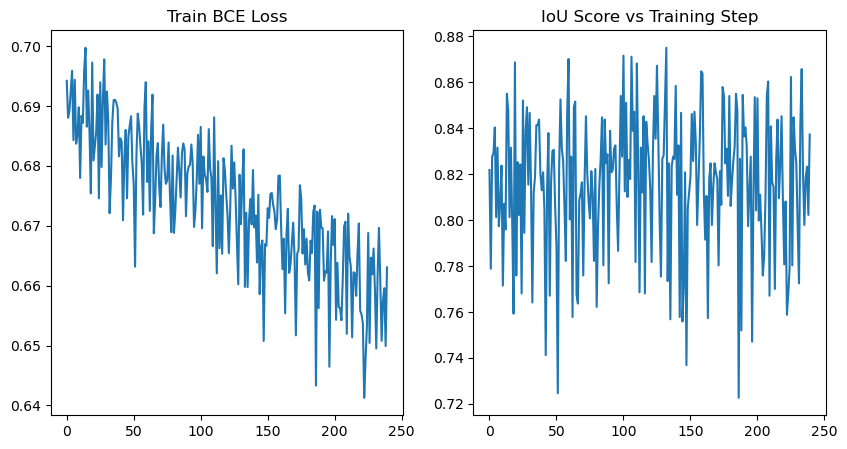

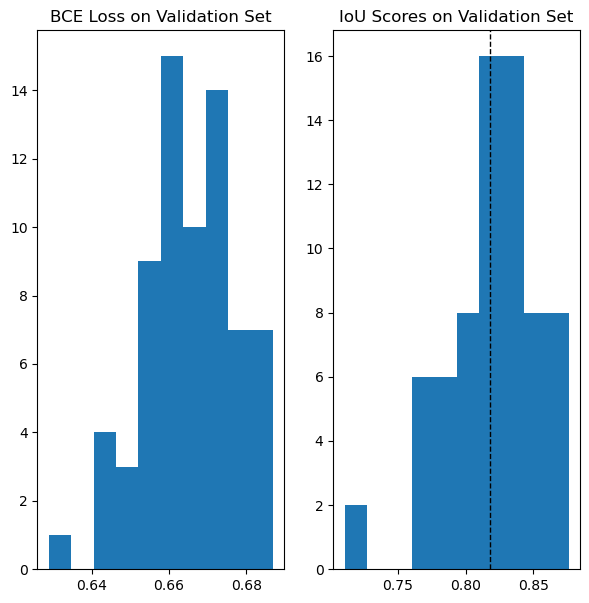

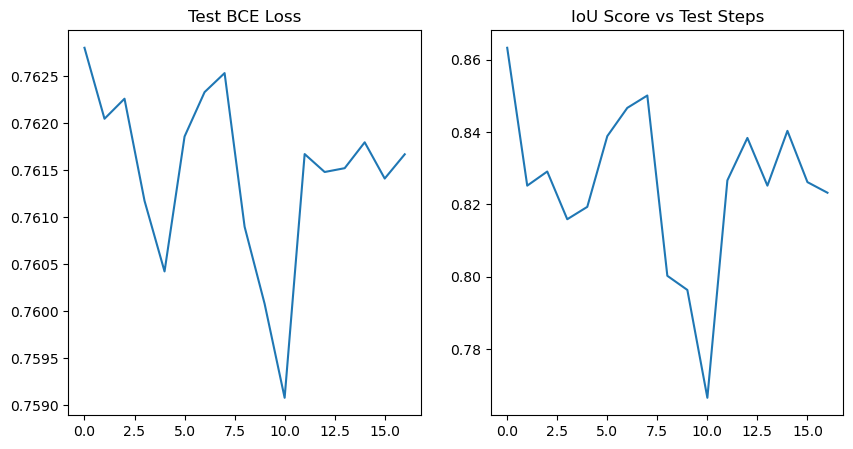

In [ ]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])
plot_test_scores(test_losses, test_scores)

IndexError: index 9 is out of bounds for axis 0 with size 9

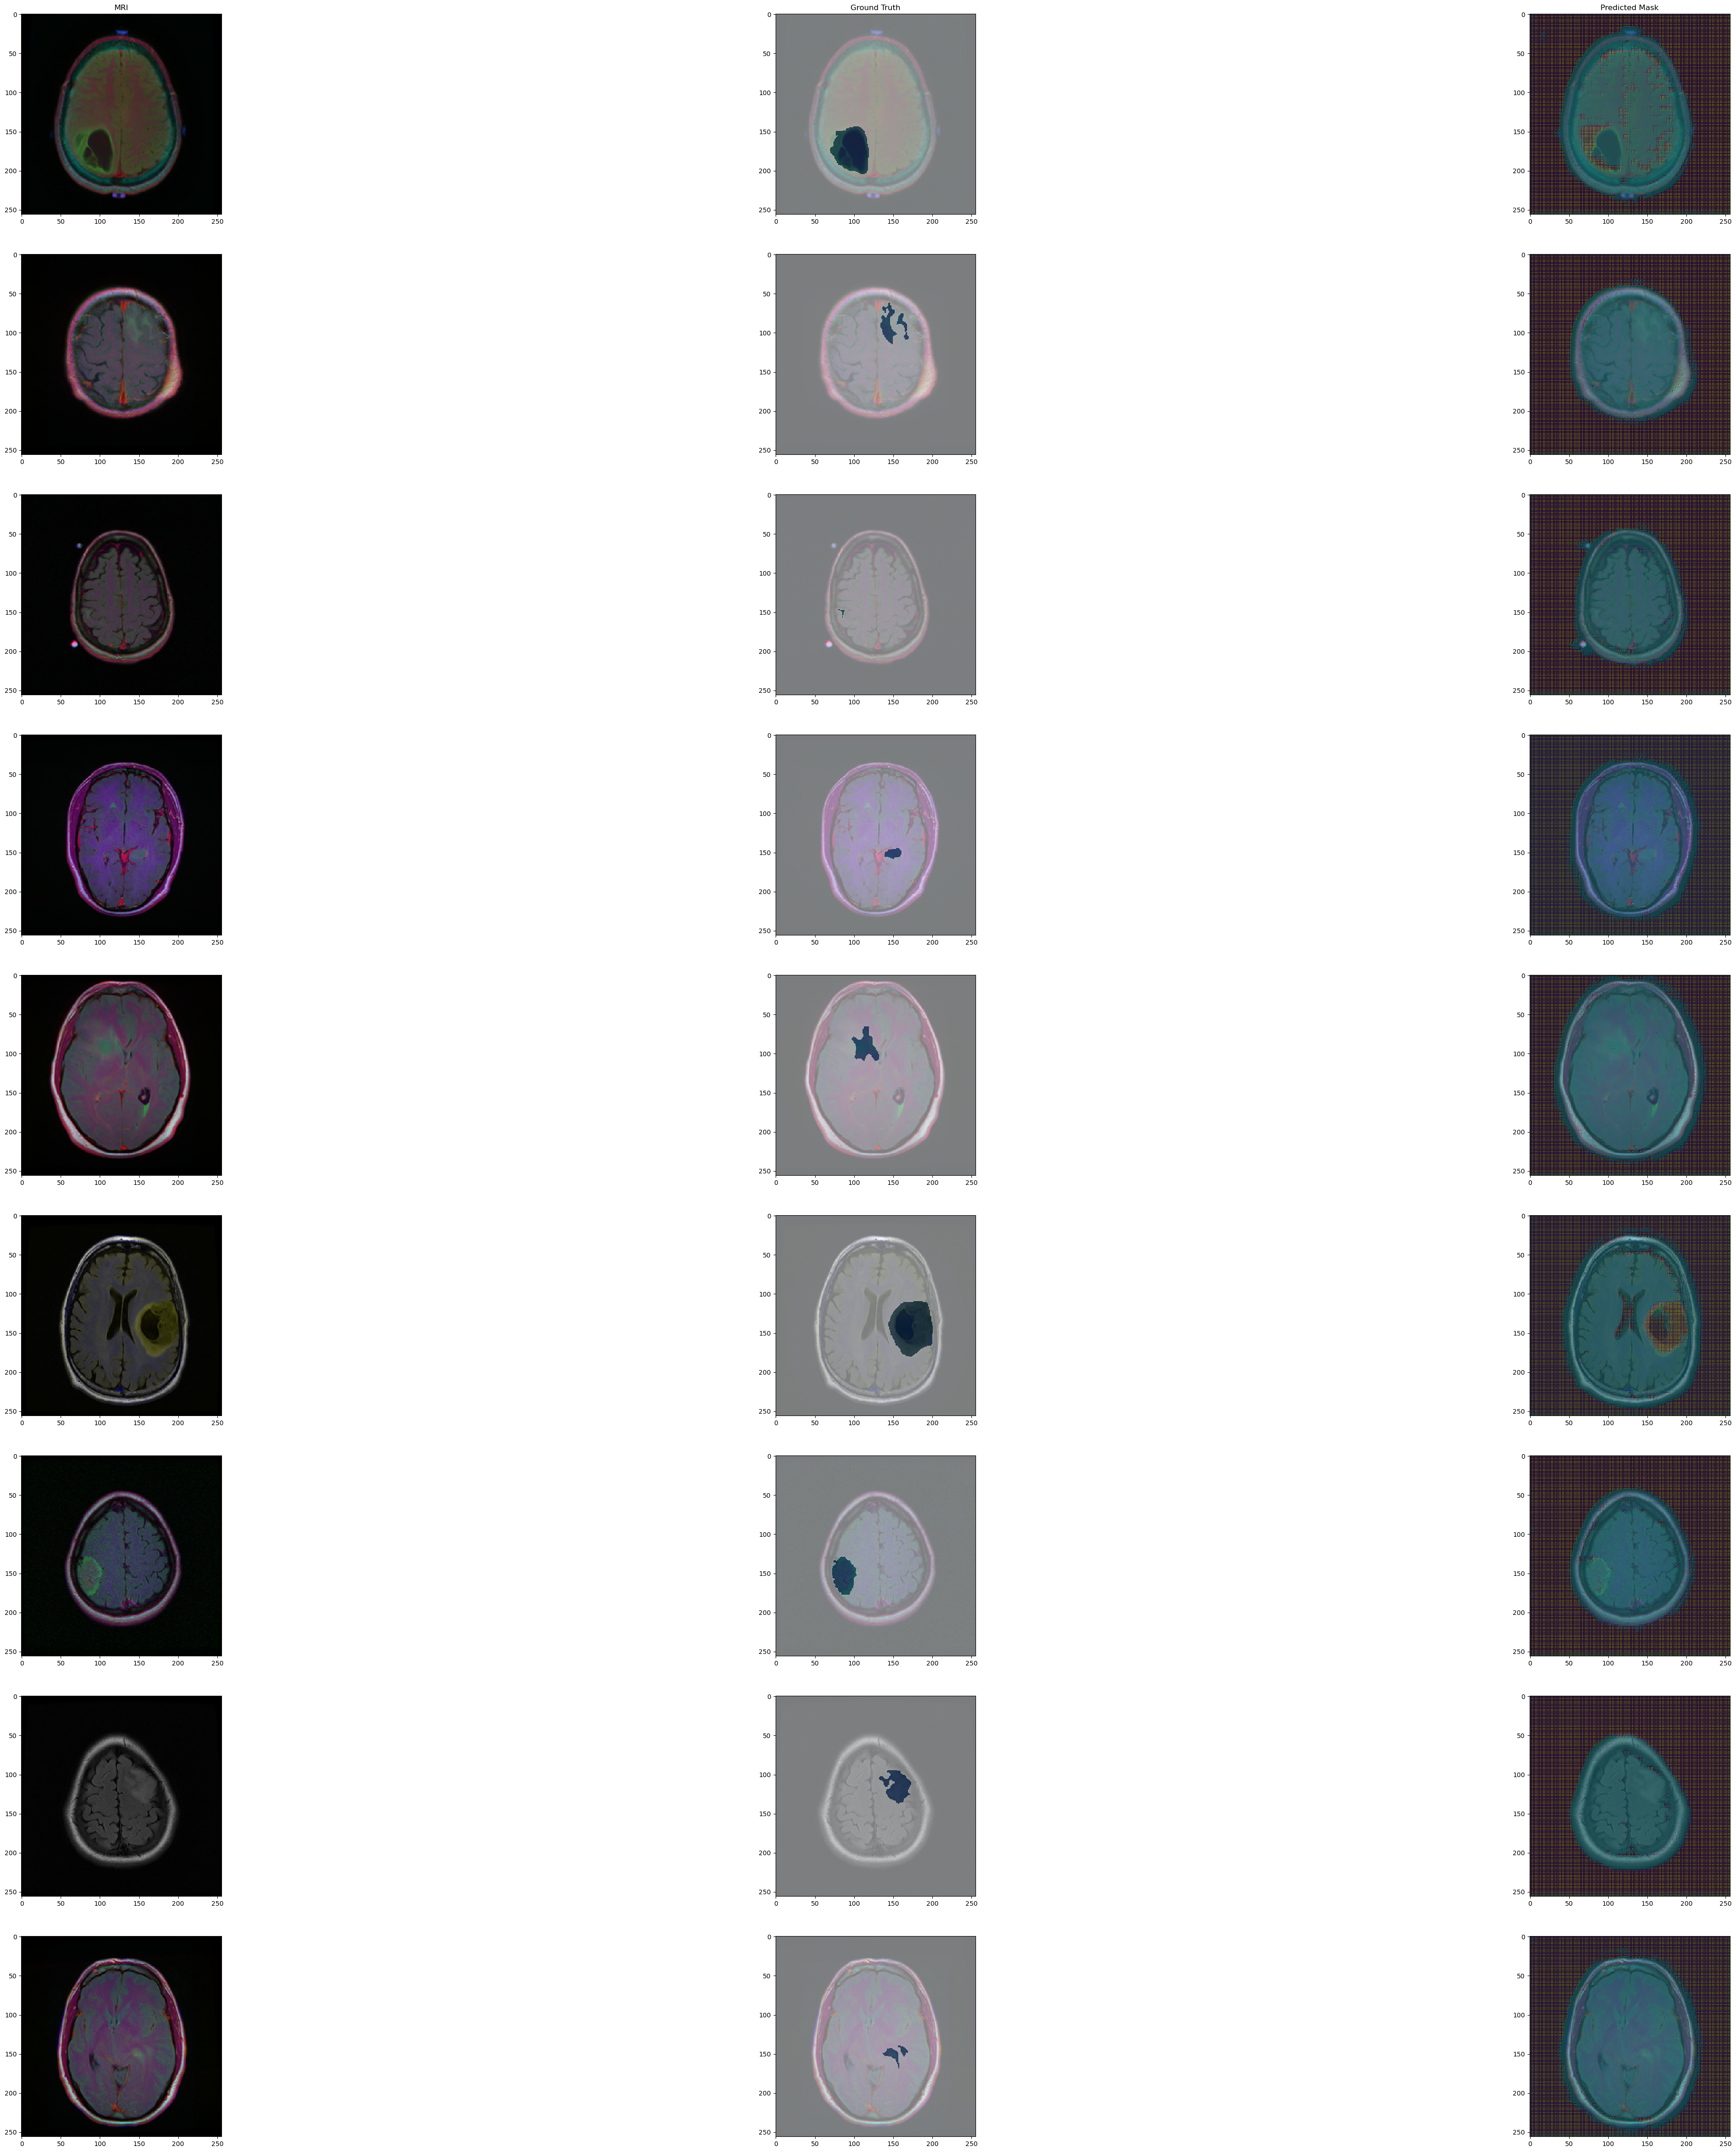

In [ ]:

# Ensure compatibility with Intel hardware (Gaudi HPU) or fallback to CPU
device = torch.device("hpu" if torch.backends.hpu.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the Quantum SegNet model and move it to the selected device
model = modelSegnetQuantum.to(device)

# Optimize the model using Intel Extension for PyTorch (IPEX)
model = ipex.optimize(model)

# Initialize the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

# Visualize segmentation results on the test set
visualize_segmentation(model, test_loader, num_samples=9, device=device)

# Clean up resources after visualization
del model
del optimizer
del loss_fn

# Clear HPU cache if running on Gaudi hardware
if device.type == 'hpu':
    htcore.hpu.empty_cache()



## Classical Segnet

In [ ]:

# Set up device for Intel HPU or fallback to CPU
device = torch.device("hpu" if torch.backends.hpu.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the SegNet model and move it to the selected device
model = modelSegnet.to(device)

# Optimize the model using Intel Extension for PyTorch (IPEX)
model = ipex.optimize(model)

# Initialize the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss

# Prepare data loaders (already defined in your source)
train_loader = train_loader
val_loader = val_loader

# Clear HPU cache if running on Gaudi hardware
if device.type == 'hpu':
    htcore.hpu.empty_cache()

# Run the experiment with the updated model and hardware configuration
results = run_experiment(
    "Segnet", 
    model, 
    num_epochs=num_epochs, 
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    clear_mem=True
)

# Clean up resources after training
del model
del optimizer
del loss_fn


Model sent to cuda
Epoch: 00001/00002 | Batch 00000/00120 | Loss: 0.5742 | IoU: 0.8486
Epoch: 00001/00002 | Batch 00001/00120 | Loss: 0.5664 | IoU: 0.8232
Epoch: 00001/00002 | Batch 00002/00120 | Loss: 0.5578 | IoU: 0.7700
Epoch: 00001/00002 | Batch 00003/00120 | Loss: 0.5628 | IoU: 0.8169
Epoch: 00001/00002 | Batch 00004/00120 | Loss: 0.5672 | IoU: 0.8267
Epoch: 00001/00002 | Batch 00005/00120 | Loss: 0.5642 | IoU: 0.7974
Epoch: 00001/00002 | Batch 00006/00120 | Loss: 0.5709 | IoU: 0.8472
Epoch: 00001/00002 | Batch 00007/00120 | Loss: 0.5747 | IoU: 0.8413
Epoch: 00001/00002 | Batch 00008/00120 | Loss: 0.5675 | IoU: 0.8374
Epoch: 00001/00002 | Batch 00009/00120 | Loss: 0.5705 | IoU: 0.8604
Epoch: 00001/00002 | Batch 00010/00120 | Loss: 0.5679 | IoU: 0.8447
Epoch: 00001/00002 | Batch 00011/00120 | Loss: 0.5631 | IoU: 0.7910
Epoch: 00001/00002 | Batch 00012/00120 | Loss: 0.5607 | IoU: 0.7803
Epoch: 00001/00002 | Batch 00013/00120 | Loss: 0.5642 | IoU: 0.8228
Epoch: 00001/00002 | Batch 00

In [ ]:
test_losses, test_scores = test_model(model=modelSegnet, test_loader=test_loader, device=device, loss_fn=nn.BCEWithLogitsLoss())

Test | Batch 00000/00017 | Loss: 0.3127 |IoU: 0.8291


MEAN TRAIN IOU: 0.8125407099723816
MEAN VAL IOU: 0.8118024553571429
MEAN TEST IOU: 0.804572582244873


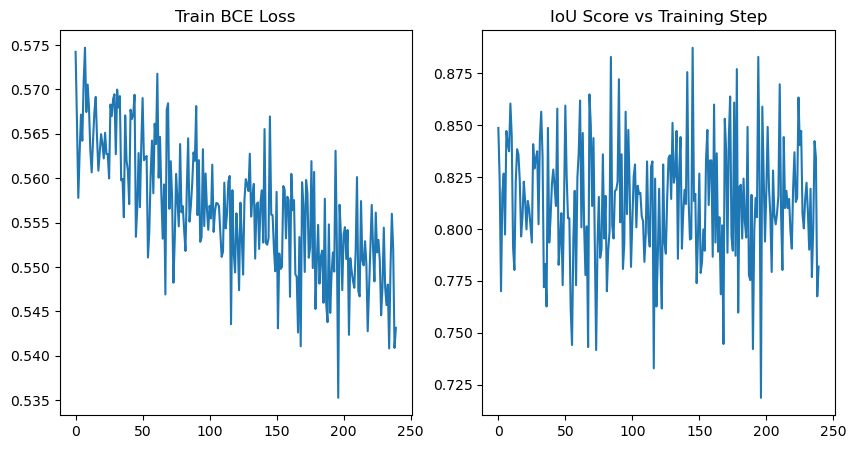

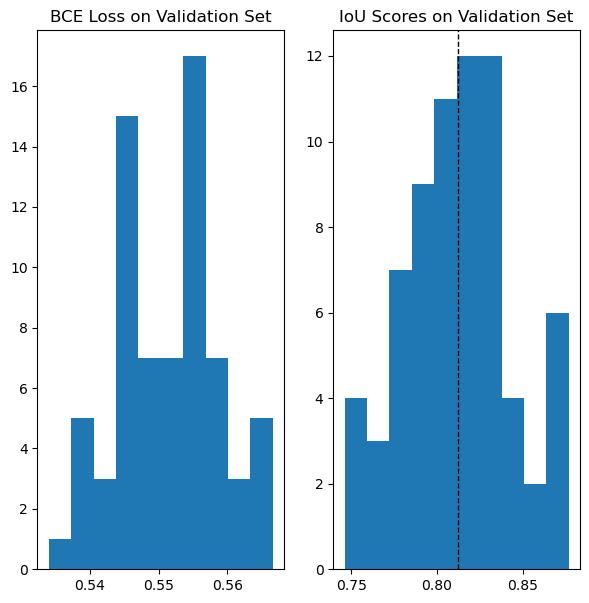

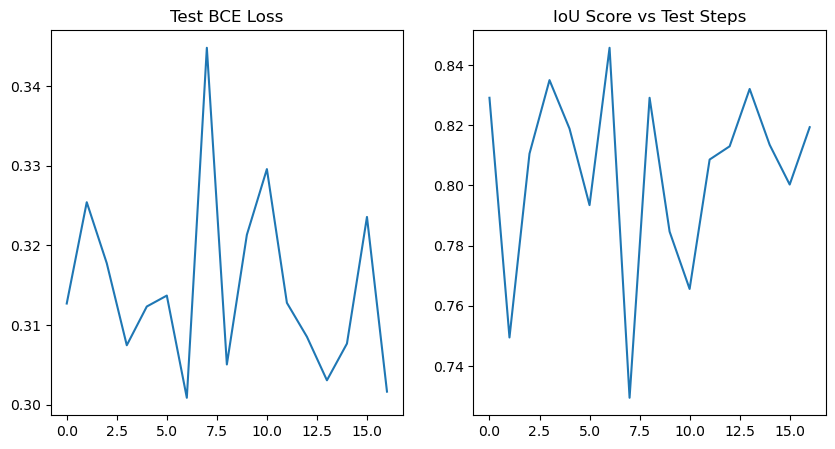

In [ ]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])
plot_test_scores(test_losses, test_scores)

IndexError: index 10 is out of bounds for axis 0 with size 10

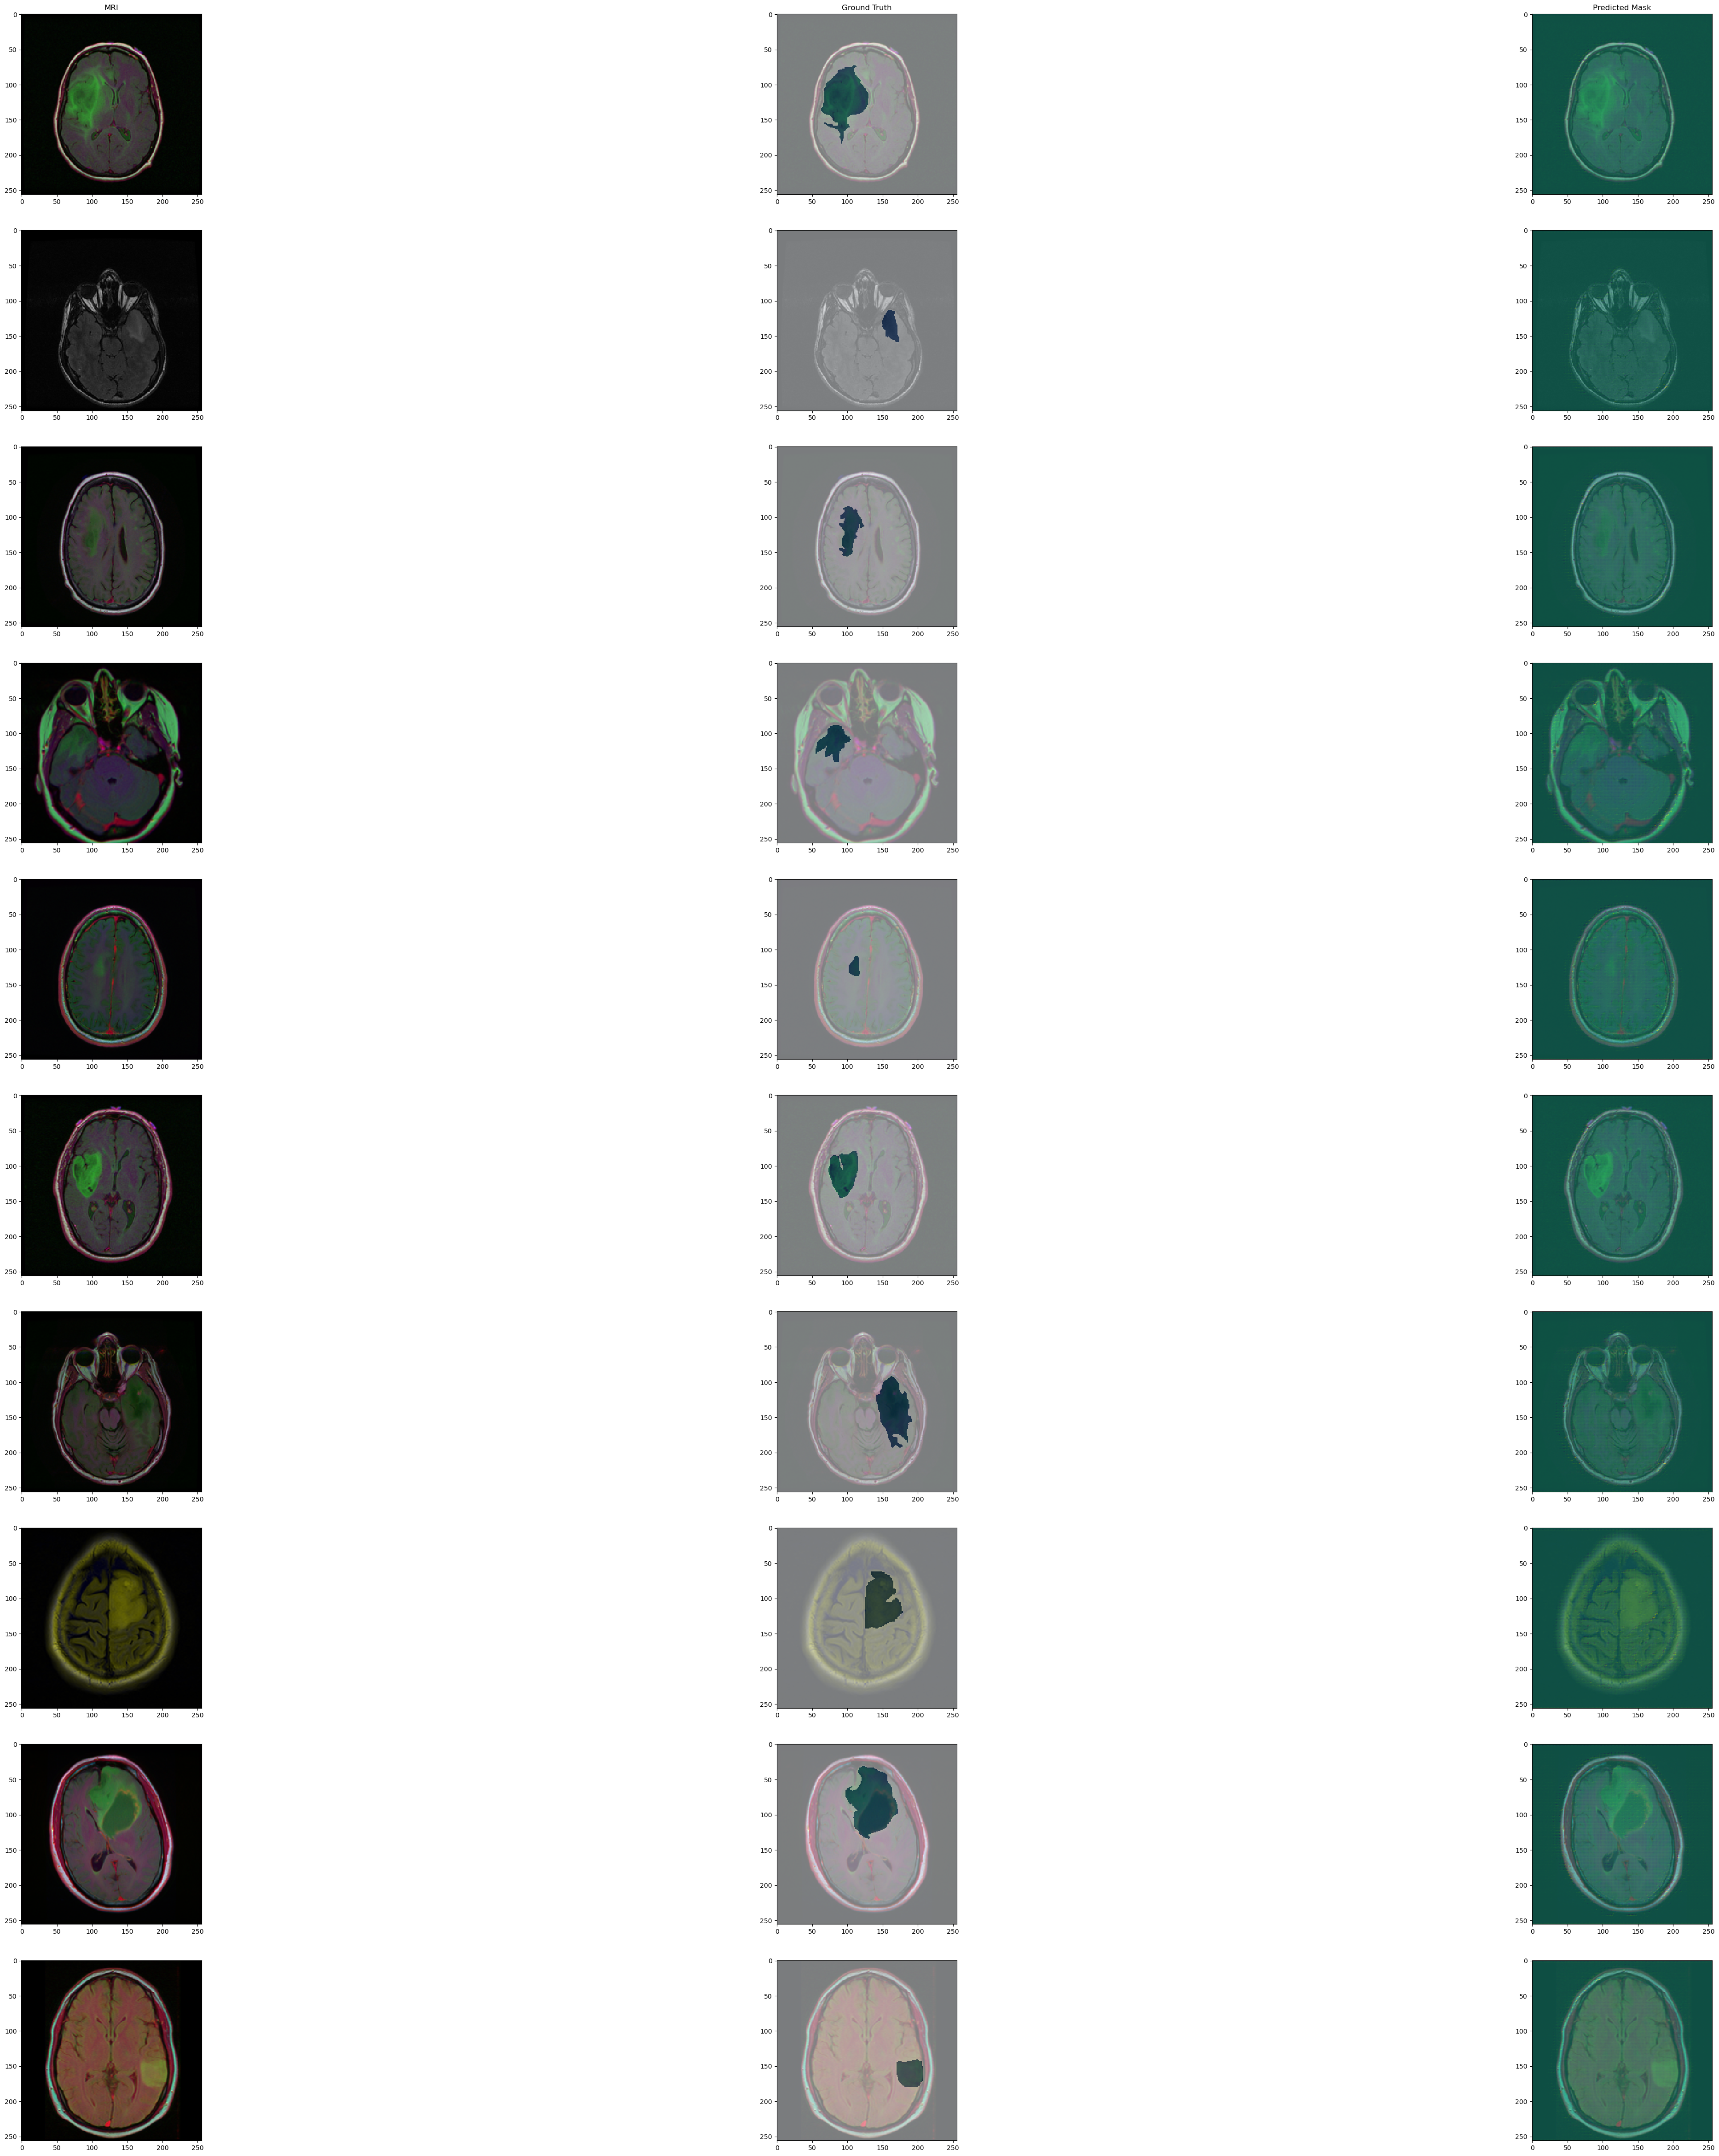

In [ ]:
# Ensure the model is using the correct device (HPU or CPU)
device = torch.device("hpu" if torch.backends.hpu.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the SegNet model and move it to the selected device
model = modelSegnet.to(device)

# Optimize the model using Intel Extension for PyTorch (IPEX)
model = ipex.optimize(model)

# Initialize the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

# Visualize segmentation results on the test set using the specified device
visualize_segmentation(model, test_loader, num_samples=10, device=device)

# Clean up resources after visualization
del model
del optimizer
del loss_fn

# Clear cache if running on Intel Gaudi HPU
if device.type == 'hpu':
    htcore.hpu.empty_cache()


In [ ]:

from openvino.runtime import Core

# Function to load and optimize models using OpenVINO
def load_openvino_model(model_path):
    """Load and optimize an ONNX model using OpenVINO."""
    ie = Core()
    model = ie.read_model(model=model_path)
    compiled_model = ie.compile_model(model=model, device_name="CPU")
    return compiled_model

# Example usage (replace 'model.onnx' with your model path)
# compiled_model = load_openvino_model('model.onnx')
